In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from utility.get_twitter import *
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, make_scorer
from utility.text_normalizer import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import sys

# Load data

In [2]:
pd.set_option("display.max_colwidth", None)

In [3]:
data = pd.read_csv('../data/tagged_tweets.csv')
data.head()

,tweet_id,tweet,revelant,sighting,lost_pet,coyote_death,eating,pet_coyote_interaction,traffic,howling
0,1.455952e+14,@OnlineAlison Several comments later… “I feed the coyotes!”,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.455952e+14,@johnlevenstein If we hadn’t defunded police there wouldn’t be so many coyotes!!!!!!!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.455933e+14,@TheOGpianoGeek That her COYOTE dues are late...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.455932e+14,"Hey Coyotes! There is a virtual PFC meeting next Wednesday, November 10th at 9:00 am. You don't wanna miss it. Click here for the Zoom link: https://t.co/2t8f4T7c9W or go to our website. #coyotepride #CHSPFC https://t.co/HDtuuiKqou",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.455930e+14,"@DunkaPeacecraft The Dems have been in power for a year, they've done nothing with it and thus have nothing to campaign on so they're forced to pull stunts like this that are sure to blow up in their face Wile E Coyote style.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`tweet` is `X` `revelant` is `y`

In [4]:
X = data['tweet']
y = data['revelant']
X.shape, y.shape

((422,), (422,))

In [5]:
y[y == 1].shape, y[y == 0].shape

((105,), (317,))

# Split data into train, validation, test

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=None)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((316,), (106,), (316,), (106,))

In [46]:
# Save training and test sets
train = pd.DataFrame({'X':X_train, 'y':y_train})
test = pd.DataFrame({'X': X_test, 'y': y_test})

In [47]:
# train.to_csv('../data/train_initial.csv', index=None)
# test.to_csv('../data/test_initial.csv', index=None)

In [48]:
train = pd.read_csv('../data/train_initial.csv')
test = pd.read_csv('../data/test_initial.csv')

In [49]:
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

# Split val_test into validation and test

In [50]:
y_train[y_train==1].sum(), y_test[y_test==1].sum()

(78.0, 27.0)

Training will be used to train all the models, validation will be used to select best model, and test will be used to test the final model

# Make Scorer for Cross Validation

The scorer or metric im going to use to gauge how good a model is logloss

In [51]:
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Create function to measure metrics

The loss we will be optimizing for is logloss

In [52]:
def print_scores(model, y_true, X_val):
    y_hat = model.predict_proba(X_val)[:,1]
    y_pred = model.predict(X_val)
    print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))
    print(f'Log Loss: {log_loss(y_true, y_hat):.5f}')
    sns.heatmap(confusion_matrix(y_true, y_pred).T, square=True, annot=True, fmt='d')

# Candidate models

The following are the models I will be selecting from:
- CountVector -> NB
- TFIDF -> NB
- CountVector -> SVG
- TFIDF -> SVG

# Model 1: Count -> NB

In [53]:
count_vec = CountVectorizer(strip_accents='ascii')
nb = MultinomialNB()
pipeline = Pipeline(steps=[('wordcount', count_vec), ('bayes', nb)])
params = {
    'wordcount__preprocessor': [tweet_preprocessor],
    'wordcount__ngram_range': [(1,2), (1,1)],
    'wordcount__stop_words': ['english'],
    'wordcount__min_df': [0, 1, 2],
    'wordcount__lowercase': [True, False],
    'bayes__alpha': [1, 2],
}

In [54]:
%%time
# wcnb = GridSearchCV(pipeline, param_grid=params, verbose=50, n_jobs=-1, cv=3, scoring=LogLoss)
wcnb = GridSearchCV(pipeline, param_grid=params, verbose=50, n_jobs=-1, cv=3, scoring='neg_log_loss')
wcnb.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 2.98 s, sys: 161 ms, total: 3.14 s
Wall time: 1min 6s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('wordcount',
                                        CountVectorizer(strip_accents='ascii')),
                                       ('bayes', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'bayes__alpha': [1, 2],
                         'wordcount__lowercase': [True, False],
                         'wordcount__min_df': [0, 1, 2],
                         'wordcount__ngram_range': [(1, 2), (1, 1)],
                         'wordcount__preprocessor': [<function tweet_preprocessor at 0x7fa179c10550>],
                         'wordcount__stop_words': ['english']},
             scoring='neg_log_loss', verbose=50)

In [55]:
wcnb.best_params_

{'bayes__alpha': 2,
 'wordcount__lowercase': True,
 'wordcount__min_df': 0,
 'wordcount__ngram_range': (1, 1),
 'wordcount__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'wordcount__stop_words': 'english'}

In [56]:
wcnb.best_score_

-0.4789029924812394

# Model 2: TFIDF -> NB

In [58]:
tfidf = TfidfVectorizer(smooth_idf=True, strip_accents='ascii')
nb = MultinomialNB()
pipeline = Pipeline([('tfidf', tfidf), ('nb', nb)])
params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [1,2],
    'tfidf__min_df': [1,2],
    'tfidf__preprocessor': [tweet_preprocessor],
    'tfidf__stop_words': ['english'],
    'tfidf__lowercase': [True, False],
    'nb__alpha': [1, 2]
}

In [59]:
# tfidfnb = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, verbose=50, cv=3, scoring=LogLoss)
tfidfnb = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, verbose=50, cv=3, scoring='neg_log_loss')

In [60]:
%%time
tfidfnb.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.52233032 -0.53170083         nan         nan -0.52475823 -0.53167121
 -0.5425149  -0.545652   -0.52233032 -0.53170083         nan         nan
 -0.52475823 -0.53167121 -0.5425149  -0.545652   -0.53643589 -0.5431306
         nan         nan -0.53726892 -0.54261475 -0.54372052 -0.545962
 -0.53643589 -0.5431306          nan         nan -0.53726892 -0.54261475
 -0.54372052 -0.545962  ]
  warnings.warn(
/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 3.22 s, sys: 43.7 ms, total: 3.26 s
Wall time: 1min 23s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(strip_accents='ascii')),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [1, 2], 'tfidf__lowercase': [True, False],
                         'tfidf__max_df': [1, 2], 'tfidf__min_df': [1, 2],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__preprocessor': [<function tweet_preprocessor at 0x7fa179c10550>],
                         'tfidf__stop_words': ['english']},
             scoring='neg_log_loss', verbose=50)

In [61]:
tfidfnb.best_params_

{'nb__alpha': 1,
 'tfidf__lowercase': True,
 'tfidf__max_df': 1,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'tfidf__stop_words': 'english'}

In [62]:
tfidfnb.best_score_

-0.5223303195353739

# Model 3: Count -> SVG

In [64]:
count_vec = CountVectorizer(strip_accents='ascii')
svmc = SVC(probability=True)
pipeline = Pipeline([('count', count_vec), ('svm', svmc)])
params = {
    'count__ngram_range': [(1,2), (1,1)],
    'count__min_df': [1],
    'count__preprocessor': [tweet_preprocessor],
    'count__stop_words': ['english'],
    'count__lowercase': [True, False],
    'svm__kernel': ['linear', 'sigmoid'],
    'svm__C': [0.5, 1, 5],
    'svm__class_weight': ['balanced'],
}

In [65]:
# cvsvm = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, verbose=30, cv=3, scoring=LogLoss)
cvsvm = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, verbose=30, cv=3, scoring='neg_log_loss')

In [66]:
%%time
cvsvm.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 3.07 s, sys: 46.9 ms, total: 3.12 s
Wall time: 1min 9s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count',
                                        CountVectorizer(strip_accents='ascii')),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'count__lowercase': [True, False],
                         'count__min_df': [1],
                         'count__ngram_range': [(1, 2), (1, 1)],
                         'count__preprocessor': [<function tweet_preprocessor at 0x7fa179c10550>],
                         'count__stop_words': ['english'],
                         'svm__C': [0.5, 1, 5],
                         'svm__class_weight': ['balanced'],
                         'svm__kernel': ['linear', 'sigmoid']},
             scoring='neg_log_loss', verbose=30)

In [67]:
cvsvm.best_params_

{'count__lowercase': False,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'count__stop_words': 'english',
 'svm__C': 0.5,
 'svm__class_weight': 'balanced',
 'svm__kernel': 'sigmoid'}

In [68]:
cvsvm.best_score_

-0.43816178084726026

# Model 4: tfidf -> SVM

In [69]:
tfidf = TfidfVectorizer(smooth_idf=True, strip_accents='ascii')
svmc = SVC(probability=True)
pipeline = Pipeline([('tfidf', tfidf), ('svm', svmc)])
params = {
    'tfidf__ngram_range': [(1,2), (1,1)],
    'tfidf__min_df': [0, 1],
    'tfidf__lowercase': [True, False],
    'tfidf__preprocessor': [tweet_preprocessor],
    'tfidf__stop_words': ['english'],
    'svm__kernel': ['linear', 'sigmoid'],
    'svm__C': [1, 5],
    'svm__class_weight': ['balanced'],
}

In [70]:
# tfidfsvm = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, verbose=50, scoring=LogLoss)
tfidfsvm = GridSearchCV(pipeline, param_grid=params, n_jobs=-1, verbose=50, scoring='neg_log_loss')

In [71]:
%%time
tfidfsvm.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 3.21 s, sys: 65.8 ms, total: 3.28 s
Wall time: 2min 21s


GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(strip_accents='ascii')),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 5], 'svm__class_weight': ['balanced'],
                         'svm__kernel': ['linear', 'sigmoid'],
                         'tfidf__lowercase': [True, False],
                         'tfidf__min_df': [0, 1],
                         'tfidf__ngram_range': [(1, 2), (1, 1)],
                         'tfidf__preprocessor': [<function tweet_preprocessor at 0x7fa179c10550>],
                         'tfidf__stop_words': ['english']},
             scoring='neg_log_loss', verbose=50)

In [72]:
tfidfsvm.best_params_

{'svm__C': 5,
 'svm__class_weight': 'balanced',
 'svm__kernel': 'linear',
 'tfidf__lowercase': True,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__preprocessor': <function utility.text_normalizer.tweet_preprocessor(tweet: str) -> str>,
 'tfidf__stop_words': 'english'}

In [73]:
tfidfsvm.best_score_

-0.4756872608853938

In [74]:
wcnb_rt = wcnb.best_estimator_
tfidfnb_rt = tfidfnb.best_estimator_
cvsvm_rt = cvsvm.best_estimator_
tfidfsvm_rt = tfidfsvm.best_estimator_
models = [wcnb_rt, tfidfnb_rt, cvsvm_rt, tfidfsvm_rt]

# Train all models with k=10 for cross validation

In [75]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import log_loss

In [76]:
for model in models:
    model.fit(X_train, y_train)

In [77]:
model_log_losses = []
for model in models:
    y_hat = cross_val_predict(model, X_train, y_train, cv=10, method='predict_proba', n_jobs=-1)
    ll = log_loss(y_train, y_hat[:,1])
    model_log_losses.append(ll)

In [78]:
for loss in model_log_losses:
    print(loss)

0.45718638908097897
0.52424520378852
0.42552038514223595
0.5085881877006514


In [79]:
print('---Best model---')
print(models[np.argmin(model_log_losses)], min(model_log_losses))
print('------')

---Best model---
Pipeline(steps=[('count',
                 CountVectorizer(lowercase=False, ngram_range=(1, 2),
                                 preprocessor=<function tweet_preprocessor at 0x7fa179c10550>,
                                 stop_words='english', strip_accents='ascii')),
                ('svm',
                 SVC(C=0.5, class_weight='balanced', kernel='sigmoid',
                     probability=True))]) 0.42552038514223595
------


In [80]:
final_model = cvsvm

              precision    recall  f1-score   support

  irrelevant       0.93      0.82      0.87        79
    relevant       0.61      0.81      0.70        27

    accuracy                           0.82       106
   macro avg       0.77      0.82      0.79       106
weighted avg       0.85      0.82      0.83       106

Log Loss: 0.41243


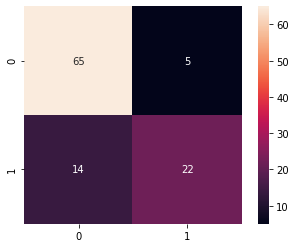

In [81]:
print_scores(final_model, y_test, X_test)

## Save final model

In [82]:
import joblib

In [83]:
with open('../bayes_model/cvsvc_01.pkl', 'wb') as f:
    joblib.dump(final_model, f)

# Compare Final Model to Current Best Model

In [84]:
best_model = joblib.load('../bayes_model/best_bayes_pipeline.pkl')

In [85]:
print(best_model.predict(['I saw a coyote this afternoon running across the road']))

[1.]


/Users/Isaacbolo/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'far', 'make', 'nt'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [86]:
print(final_model.predict(['I saw a coyote this afternoon running across the road']))

[1.]


              precision    recall  f1-score   support

  irrelevant       0.94      0.91      0.92        79
    relevant       0.76      0.81      0.79        27

    accuracy                           0.89       106
   macro avg       0.85      0.86      0.85       106
weighted avg       0.89      0.89      0.89       106

Log Loss: 0.44803


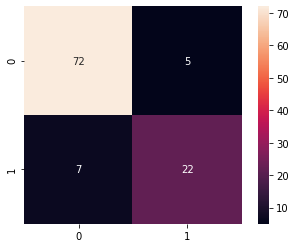

In [87]:
print_scores(best_model, y_test, X_test)

              precision    recall  f1-score   support

  irrelevant       0.93      0.82      0.87        79
    relevant       0.61      0.81      0.70        27

    accuracy                           0.82       106
   macro avg       0.77      0.82      0.79       106
weighted avg       0.85      0.82      0.83       106

Log Loss: 0.41243


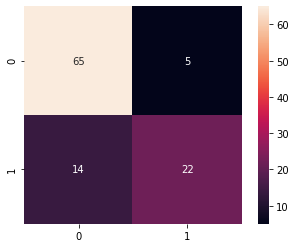

In [88]:
print_scores(final_model, y_test, X_test)

The final model preforms worse than the current best model. The current best model will be the one used.

**HOWEVER**, I think the reason why the final model is performing better is because there is data leakage from the initial model to the test set. The current best model has very likely seen some of the data in the current test set, therefore, performing better than the final model.